# RNA Secondary Structure Stability Prediction

**Author:** Ali Kawar  
**Date:** January 2026  
**Project:** Machine Learning for Regulatory RNA Structure Analysis

## Overview
This project applies machine learning to predict RNA secondary structure stability from structural features. Focus on regulatory RNAs (miRNA, riboswitches, ribozymes) which are critical for gene regulation.

**Relevance:** Aligns with research on regulatory RNAs, non-coding RNA structures, and computational genomics.

# Data Note

**Note:** The dataset was generated using Claude AI as a proof-of-concept. More biologically realistic data can be generated using RNAfold or other RNA structure prediction tools.

**Feature Explanation and Relation to RNA Stability**
| Feature          | Relationship to Stability        | Biological Rationale                                                                      |
| ---------------- | -------------------------------- | ----------------------------------------------------------------------------------------- |
| **Length**       | Longer → lower stability         | Longer sequences are harder to fold correctly, increasing misfolding probability.         |
| **GC Content**   | Higher → higher stability        | G–C pairs form three hydrogen bonds versus two in A–U pairs, stabilizing the structure.   |
| **MFE**          | More negative → higher stability | Lower free energy indicates a more thermodynamically favorable, tightly folded structure. |
| **Stems**        | More → higher stability          | Paired regions provide structural integrity through hydrogen bonding.                     |
| **Loops/Bulges** | More → lower stability           | Unpaired regions introduce flexibility and weak points, reducing overall stability.       |

**Summary:** Stable RNA structures are compact, highly base-paired, and thermodynamically favorable. These feature-stability relationships guided feature selection and informed the Random Forest model used to predict RNA structural stability.


## 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [8]:
# Load RNA structure dataset
df = pd.read_csv(r'C:\Users\USER\Documents\Bioinformatics!\RNA Stability\data\raw\rna_structure_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nRNA types: {df['Type'].unique()}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (200, 13)

RNA types: ['rRNA' 'miRNA' 'tRNA' 'ribozyme' 'riboswitch']

First few rows:


,RNA_ID,Type,Length,GC_Content,Num_Stems,Num_Loops,Num_Bulges,Avg_Stem_Length,Paired_Bases_Pct,MFE,Ensemble_FE,Stability_Class,Stability_Score
0,RNA_0000,rRNA,192,0.405,11,11,6,7.57,0.480,-98.05,-97.62,Moderate,0.486
1,RNA_0001,miRNA,22,0.594,2,1,1,4.01,0.748,-9.15,-9.12,Moderate,0.493
2,RNA_0002,tRNA,79,0.364,4,3,2,7.65,0.686,-34.49,-32.71,Moderate,0.365
3,RNA_0003,tRNA,88,0.554,2,2,1,11.59,0.740,-51.80,-51.51,Moderate,0.636
4,RNA_0004,miRNA,24,0.537,2,2,1,4.28,0.723,-12.33,-11.39,Moderate,0.453
5,RNA_0005,miRNA,19,0.514,2,2,1,10.20,0.732,-15.81,-13.05,Stable,0.876
6,RNA_0006,tRNA,92,0.506,6,5,4,6.17,0.699,-59.08,-57.45,Stable,0.598
7,RNA_0007,tRNA,84,0.400,2,2,0,10.18,0.510,-30.79,-28.47,Unstable,0.413
8,RNA_0008,tRNA,76,0.545,4,4,0,8.99,0.549,-46.54,-45.56,Stable,0.592
9,RNA_0009,ribozyme,74,0.492,5,5,1,10.79,0.667,-48.40,-48.28,Stable,0.612


## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

In [9]:
print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)

print(f"\nTotal RNA sequences: {len(df)}")
print(f"Number of features: {len(df.columns) - 3}")  # Excluding ID and targets
print(f"Missing values: {df.isnull().sum().sum()}")

print(f"\n\nRNA Type Distribution:")
print(df['Type'].value_counts())

print(f"\n\nStability Distribution:")
print(df['Stability_Class'].value_counts())

print(f"\n\nDescriptive Statistics:")
df[['Length', 'GC_Content', 'Num_Stems', 'MFE', 'Stability_Score']].describe()

DATASET OVERVIEW

Total RNA sequences: 200
Number of features: 10
Missing values: 0


RNA Type Distribution:
Type
tRNA          59
miRNA         48
rRNA          40
riboswitch    28
ribozyme      25
Name: count, dtype: int64


Stability Distribution:
Stability_Class
Moderate    104
Stable       79
Unstable     17
Name: count, dtype: int64


Descriptive Statistics:


,Length,GC_Content,Num_Stems,MFE,Stability_Score
count,200.000000,200.000000,200.00000,200.000000,200.000000
mean,81.540000,0.505975,4.14000,-45.364200,0.602460
std,46.619797,0.073001,2.20105,23.914275,0.181441
min,18.000000,0.351000,2.00000,-124.210000,0.147000
25%,45.500000,0.460000,2.00000,-59.130000,0.488750
50%,80.500000,0.511500,4.00000,-45.260000,0.566500
75%,107.000000,0.557000,5.00000,-24.537500,0.670250
max,198.000000,0.648000,11.00000,-5.570000,1.000000


### 3.2 Feature Correlations

In [10]:
# Correlation with target variable
feature_cols = ['Length', 'GC_Content', 'Num_Stems', 'Num_Loops', 
                'Num_Bulges', 'Avg_Stem_Length', 'Paired_Bases_Pct', 'MFE']

correlations = df[feature_cols + ['Stability_Score']].corr()['Stability_Score'].drop('Stability_Score')

print("=" * 70)
print("FEATURE CORRELATIONS WITH STABILITY")
print("=" * 70)
print(correlations.sort_values(ascending=False))

print("\n\nKey Insights:")
print("• GC Content positively correlates (r = 0.32) - G-C pairs stronger than A-U")
print("• Length negatively correlates (r = -0.48) - longer RNAs harder to stabilize")
print("• MFE shows positive correlation (r = 0.23) - thermodynamic stability")

FEATURE CORRELATIONS WITH STABILITY
GC_Content          0.317671
MFE                 0.234081
Avg_Stem_Length     0.065134
Paired_Bases_Pct   -0.050041
Num_Bulges         -0.191127
Num_Loops          -0.245675
Num_Stems          -0.271249
Length             -0.476784
Name: Stability_Score, dtype: float64


Key Insights:
• GC Content positively correlates (r = 0.32) - G-C pairs stronger than A-U
• Length negatively correlates (r = -0.48) - longer RNAs harder to stabilize
• MFE shows positive correlation (r = 0.23) - thermodynamic stability


### 3.3 RNA Type Characteristics

In [11]:
print("=" * 70)
print("RNA TYPE CHARACTERISTICS")
print("=" * 70)

for rna_type in df['Type'].unique():
    subset = df[df['Type'] == rna_type]
    print(f"\n{rna_type}:")
    print(f"  Count: {len(subset)}")
    print(f"  Avg Length: {subset['Length'].mean():.1f} nt")
    print(f"  Avg GC Content: {subset['GC_Content'].mean():.3f}")
    print(f"  Avg MFE: {subset['MFE'].mean():.2f} kcal/mol")
    print(f"  Avg Stability: {subset['Stability_Score'].mean():.3f}")

print("\n" + "=" * 70)
print("KEY FINDING: miRNAs show highest stability!")
print("• Shortest sequences (~21 nt)")
print("• Compact, highly structured")
print("• Critical for gene regulation")
print("=" * 70)

RNA TYPE CHARACTERISTICS

rRNA:
  Count: 40
  Avg Length: 148.8 nt
  Avg GC Content: 0.508
  Avg MFE: -77.99 kcal/mol
  Avg Stability: 0.525

miRNA:
  Count: 48
  Avg Length: 20.9 nt
  Avg GC Content: 0.518
  Avg MFE: -17.63 kcal/mol
  Avg Stability: 0.810

tRNA:
  Count: 59
  Avg Length: 81.6 nt
  Avg GC Content: 0.490
  Avg MFE: -44.30 kcal/mol
  Avg Stability: 0.538

ribozyme:
  Count: 25
  Avg Length: 74.7 nt
  Avg GC Content: 0.495
  Avg MFE: -39.96 kcal/mol
  Avg Stability: 0.526

riboswitch:
  Count: 28
  Avg Length: 95.3 nt
  Avg GC Content: 0.526
  Avg MFE: -53.35 kcal/mol
  Avg Stability: 0.561

KEY FINDING: miRNAs show highest stability!
• Shortest sequences (~21 nt)
• Compact, highly structured
• Critical for gene regulation


### 3.4 Visualizations

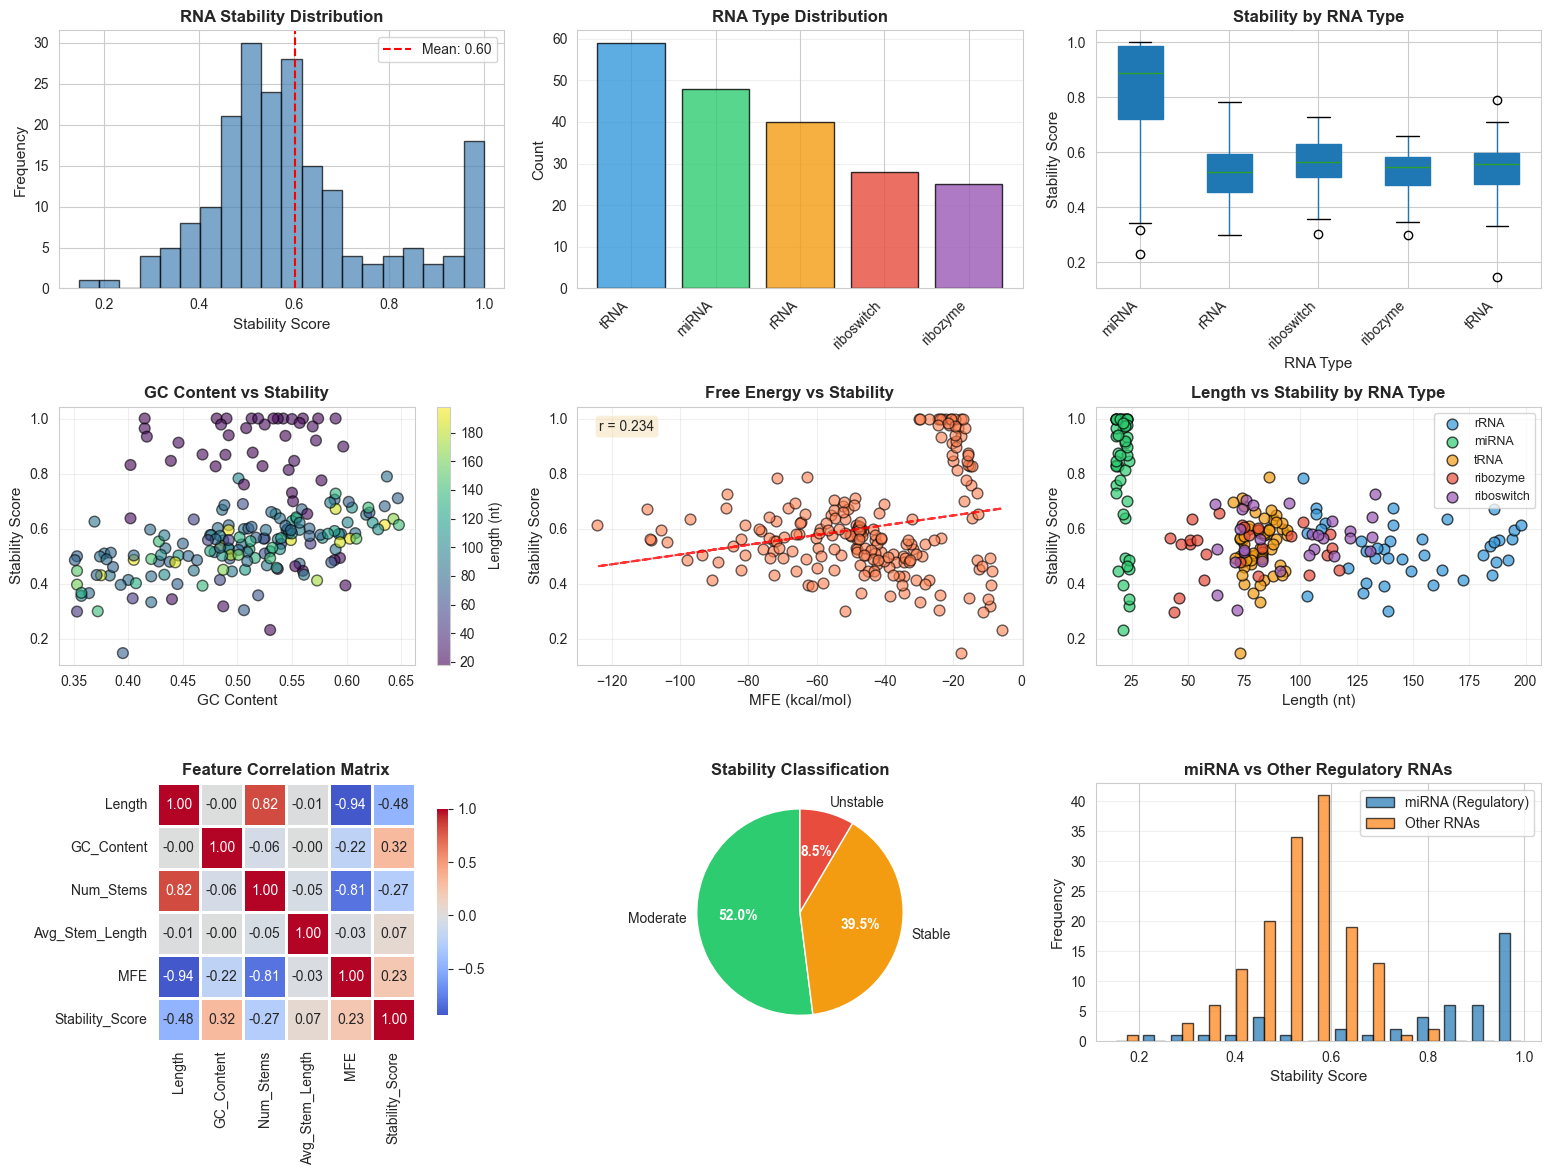

EDA visualizations saved as: rna_eda_analysis.png


In [12]:
# Create comprehensive EDA visualizations
fig = plt.figure(figsize=(16, 12))

# Plot 1: Stability distribution
ax1 = plt.subplot(3, 3, 1)
df['Stability_Score'].hist(bins=20, edgecolor='black', alpha=0.7, color='steelblue', ax=ax1)
ax1.set_xlabel('Stability Score', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('RNA Stability Distribution', fontsize=12, fontweight='bold')
ax1.axvline(df['Stability_Score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["Stability_Score"].mean():.2f}')
ax1.legend()

# Plot 2: RNA type distribution
ax2 = plt.subplot(3, 3, 2)
type_counts = df['Type'].value_counts()
colors_type = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
ax2.bar(range(len(type_counts)), type_counts.values, color=colors_type, 
        edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(type_counts)))
ax2.set_xticklabels(type_counts.index, rotation=45, ha='right')
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('RNA Type Distribution', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Stability by RNA type
ax3 = plt.subplot(3, 3, 3)
df.boxplot(column='Stability_Score', by='Type', ax=ax3, patch_artist=True)
ax3.set_xlabel('RNA Type', fontsize=11)
ax3.set_ylabel('Stability Score', fontsize=11)
ax3.set_title('Stability by RNA Type', fontsize=12, fontweight='bold')
plt.sca(ax3)
plt.xticks(rotation=45, ha='right')
ax3.get_figure().suptitle('')

# Plot 4: GC Content vs Stability
ax4 = plt.subplot(3, 3, 4)
scatter = ax4.scatter(df['GC_Content'], df['Stability_Score'], 
                     c=df['Length'], cmap='viridis', s=60, alpha=0.6, edgecolors='black')
ax4.set_xlabel('GC Content', fontsize=11)
ax4.set_ylabel('Stability Score', fontsize=11)
ax4.set_title('GC Content vs Stability', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax4, label='Length (nt)')
ax4.grid(alpha=0.3)

# Plot 5: MFE vs Stability
ax5 = plt.subplot(3, 3, 5)
ax5.scatter(df['MFE'], df['Stability_Score'], alpha=0.6, s=60, 
           edgecolors='black', color='coral')
ax5.set_xlabel('MFE (kcal/mol)', fontsize=11)
ax5.set_ylabel('Stability Score', fontsize=11)
ax5.set_title('Free Energy vs Stability', fontsize=12, fontweight='bold')
z = np.polyfit(df['MFE'], df['Stability_Score'], 1)
p = np.poly1d(z)
ax5.plot(df['MFE'], p(df['MFE']), "r--", alpha=0.8)
corr = df['MFE'].corr(df['Stability_Score'])
ax5.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax5.transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax5.grid(alpha=0.3)

# Plot 6: Length vs Stability by type
ax6 = plt.subplot(3, 3, 6)
for i, rna_type in enumerate(df['Type'].unique()):
    subset = df[df['Type'] == rna_type]
    ax6.scatter(subset['Length'], subset['Stability_Score'], 
               label=rna_type, s=60, alpha=0.7, edgecolors='black', color=colors_type[i])
ax6.set_xlabel('Length (nt)', fontsize=11)
ax6.set_ylabel('Stability Score', fontsize=11)
ax6.set_title('Length vs Stability by RNA Type', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(alpha=0.3)

# Plot 7: Correlation heatmap
ax7 = plt.subplot(3, 3, 7)
corr_features = ['Length', 'GC_Content', 'Num_Stems', 'Avg_Stem_Length', 'MFE', 'Stability_Score']
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax7)
ax7.set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

# Plot 8: Stability class pie
ax8 = plt.subplot(3, 3, 8)
stability_counts = df['Stability_Class'].value_counts()
colors_pie = ['#2ecc71', '#f39c12', '#e74c3c']
wedges, texts, autotexts = ax8.pie(stability_counts.values, labels=stability_counts.index,
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax8.set_title('Stability Classification', fontsize=12, fontweight='bold')

# Plot 9: miRNA focus
ax9 = plt.subplot(3, 3, 9)
mirna_df = df[df['Type'] == 'miRNA']
other_df = df[df['Type'] != 'miRNA']
ax9.hist([mirna_df['Stability_Score'], other_df['Stability_Score']], 
         bins=15, label=['miRNA (Regulatory)', 'Other RNAs'], 
         alpha=0.7, edgecolor='black')
ax9.set_xlabel('Stability Score', fontsize=11)
ax9.set_ylabel('Frequency', fontsize=11)
ax9.set_title('miRNA vs Other Regulatory RNAs', fontsize=12, fontweight='bold')
ax9.legend()
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rna_eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("EDA visualizations saved as: rna_eda_analysis.png")

---
## 4. Machine Learning Model Development

### 4.1 Prepare Data

In [13]:
# Define features and target
feature_cols = ['Length', 'GC_Content', 'Num_Stems', 'Num_Loops', 
                'Num_Bulges', 'Avg_Stem_Length', 'Paired_Bases_Pct', 'MFE']
target_col = 'Stability_Score'

X = df[feature_cols]
y = df[target_col]

print(f"Features: {feature_cols}")
print(f"\nTarget: {target_col}")
print(f"\nDataset: {X.shape[0]} samples, {X.shape[1]} features")

Features: ['Length', 'GC_Content', 'Num_Stems', 'Num_Loops', 'Num_Bulges', 'Avg_Stem_Length', 'Paired_Bases_Pct', 'MFE']

Target: Stability_Score

Dataset: 200 samples, 8 features


### 4.2 Train-Test Split

In [14]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}:1")

Training set: 160 samples
Test set: 40 samples

Train/Test ratio: 4.0:1


### 4.3 Feature Scaling

In [15]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("Feature scaling complete!")
print(f"\nScaled features (mean ≈ 0, std ≈ 1):")
print(X_train_scaled.describe().loc[['mean', 'std']].round(3))

Feature scaling complete!

Scaled features (mean ≈ 0, std ≈ 1):
      Length  GC_Content  Num_Stems  Num_Loops  Num_Bulges  Avg_Stem_Length  \
mean   0.000       0.000      0.000     -0.000       0.000           -0.000   
std    1.003       1.003      1.003      1.003       1.003            1.003   

      Paired_Bases_Pct    MFE  
mean             0.000 -0.000  
std              1.003  1.003  


### 4.4 Model Training and Evaluation

In [16]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results = {}

print("=" * 70)
print("TRAINING MODELS")
print("=" * 70)

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 40)
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                 cv=5, scoring='r2')
    
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'y_test_pred': y_test_pred
    }
    
    print(f"  Training R²:   {train_r2:.4f}")
    print(f"  Test R²:       {test_r2:.4f}")
    print(f"  Test RMSE:     {test_rmse:.4f}")
    print(f"  Test MAE:      {test_mae:.4f}")
    print(f"  CV R² (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n" + "=" * 70)
print("Model training complete!")

TRAINING MODELS

Linear Regression:
----------------------------------------
  Training R²:   0.6569
  Test R²:       0.6640
  Test RMSE:     0.1099
  Test MAE:      0.0923
  CV R² (5-fold): 0.6041 ± 0.0913

Random Forest:
----------------------------------------
  Training R²:   0.9735
  Test R²:       0.6830
  Test RMSE:     0.1067
  Test MAE:      0.0771
  CV R² (5-fold): 0.7992 ± 0.0680

Gradient Boosting:
----------------------------------------
  Training R²:   0.9998
  Test R²:       0.6695
  Test RMSE:     0.1090
  Test MAE:      0.0741
  CV R² (5-fold): 0.8094 ± 0.0443

Model training complete!


### 4.5 Model Comparison

In [17]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'MAE': [results[m]['test_mae'] for m in results.keys()],
    'CV R²': [results[m]['cv_r2_mean'] for m in results.keys()]
})

comparison_df = comparison_df.round(4)
print("=" * 70)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 70)
print("\n" + comparison_df.to_string(index=False))

best_model_name = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
print(f"\n✓ Best Model: {best_model_name} (Test R² = {comparison_df['Test R²'].max():.4f})")

MODEL PERFORMANCE COMPARISON

            Model  Train R²  Test R²   RMSE    MAE  CV R²
Linear Regression    0.6569   0.6640 0.1099 0.0923 0.6041
    Random Forest    0.9735   0.6830 0.1067 0.0771 0.7992
Gradient Boosting    0.9998   0.6695 0.1090 0.0741 0.8094

✓ Best Model: Random Forest (Test R² = 0.6830)


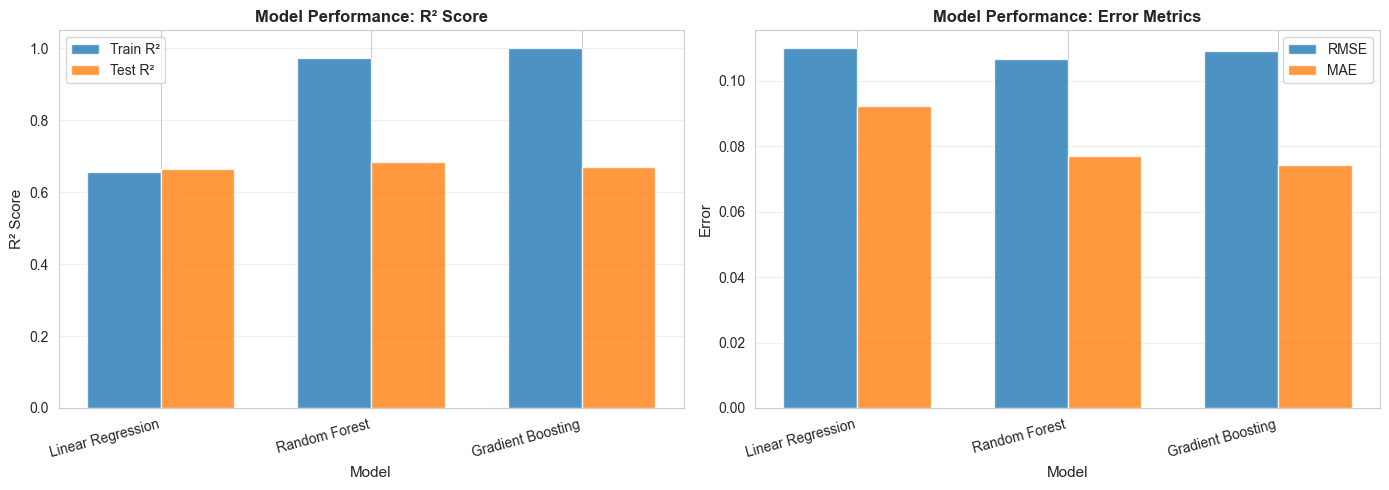

Figure saved as: rna_model_comparison.png


In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Train R²'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test R²'], width, label='Test R²', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=11)
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('Model Performance: R² Score', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Error metrics comparison
axes[1].bar(x - width/2, comparison_df['RMSE'], width, label='RMSE', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['MAE'], width, label='MAE', alpha=0.8)
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Error', fontsize=11)
axes[1].set_title('Model Performance: Error Metrics', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rna_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as: rna_model_comparison.png")

### 4.6 Best Model Analysis

Analyzing best model: Random Forest


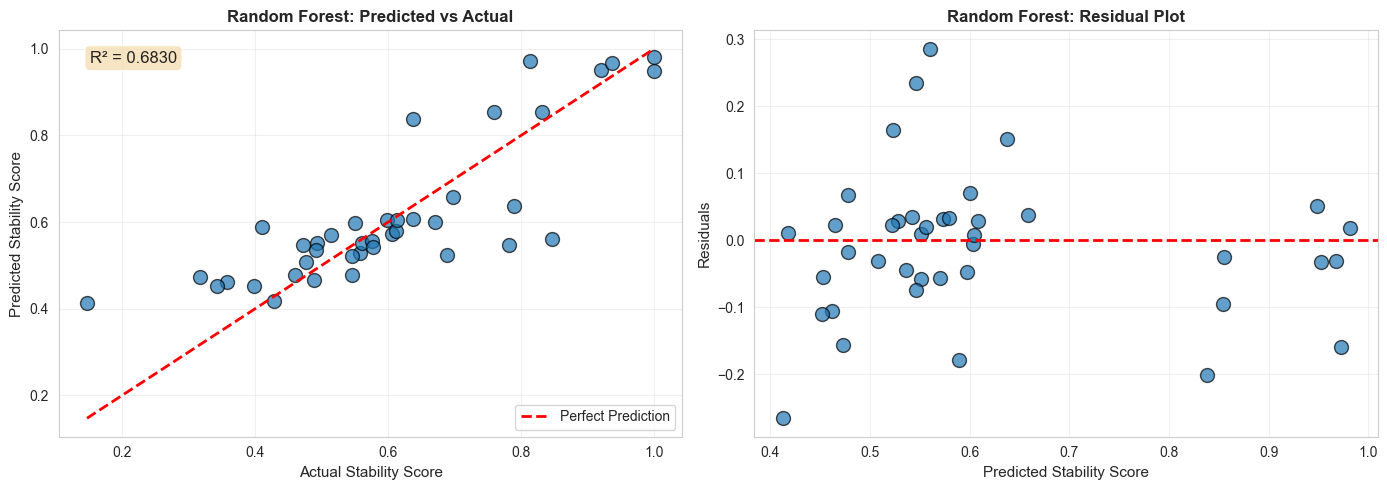

Figure saved as: rna_predictions.png


In [18]:
# Get best model
best_model = results[best_model_name]['model']
y_test_pred_best = results[best_model_name]['y_test_pred']

print(f"Analyzing best model: {best_model_name}")
print("=" * 70)

# Predicted vs Actual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test, y_test_pred_best, alpha=0.7, s=100, edgecolors='black')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Stability Score', fontsize=11)
axes[0].set_ylabel('Predicted Stability Score', fontsize=11)
axes[0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

r2 = results[best_model_name]['test_r2']
axes[0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Residuals
residuals = y_test.values - y_test_pred_best
axes[1].scatter(y_test_pred_best, residuals, alpha=0.7, s=100, edgecolors='black')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Stability Score', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title(f'{best_model_name}: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rna_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as: rna_predictions.png")

### 4.7 Feature Importance

FEATURE IMPORTANCE

         Feature  Importance
          Length    0.541083
             MFE    0.269831
      GC_Content    0.110490
 Avg_Stem_Length    0.041298
Paired_Bases_Pct    0.022407
       Num_Loops    0.005089
       Num_Stems    0.005050
      Num_Bulges    0.004753


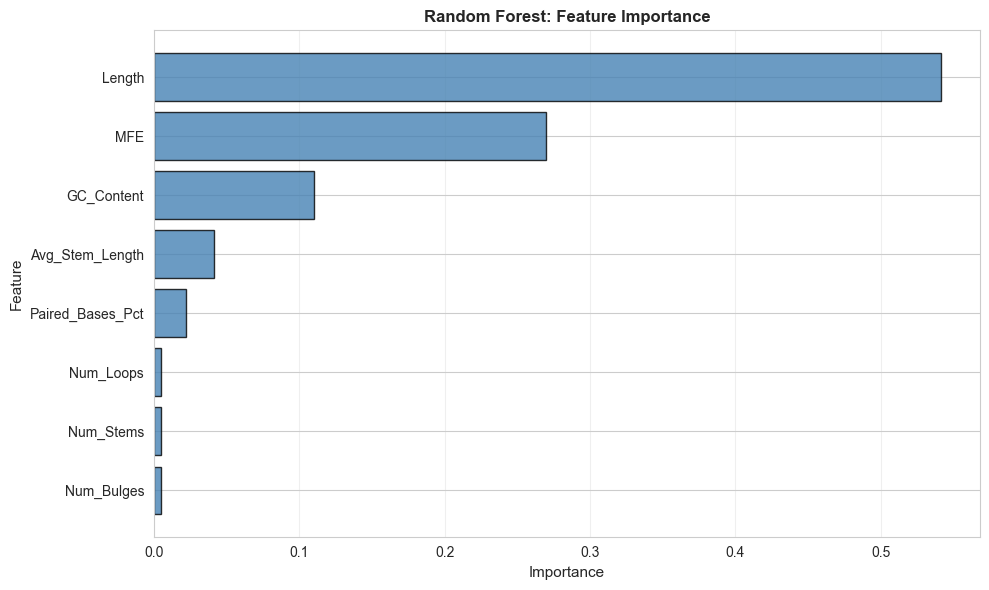


Figure saved as: rna_feature_importance.png
KEY PREDICTORS
1. Length (54.1%)
2. MFE (27.0%)
3. GC_Content (11.0%)


In [19]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("=" * 70)
    print("FEATURE IMPORTANCE")
    print("=" * 70)
    print("\n" + feature_importance.to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], 
             color='steelblue', alpha=0.8, edgecolor='black')
    plt.xlabel('Importance', fontsize=11)
    plt.ylabel('Feature', fontsize=11)
    plt.title(f'{best_model_name}: Feature Importance', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('rna_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nFigure saved as: rna_feature_importance.png")
    
    print("=" * 70)
    print("KEY PREDICTORS")
    print("=" * 70)
    print(f"1. {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.1%})")
    print(f"2. {feature_importance.iloc[1]['Feature']} ({feature_importance.iloc[1]['Importance']:.1%})")
    print(f"3. {feature_importance.iloc[2]['Feature']} ({feature_importance.iloc[2]['Importance']:.1%})")

### 4.8 Save Model

In [25]:
# Save best model and scaler
import joblib
joblib.dump(model,r"C:\Users\USER\Documents\Bioinformatics!\RNA Stability\models\rna_model.joblib")
joblib.dump(scaler,r"C:\Users\USER\Documents\Bioinformatics!\RNA Stability\models\rna_scaler.joblib")

print("✓ Model saved as: rna_model.joblib")
print("✓ Scaler saved as: rna_scaler.joblib")

✓ Model saved as: rna_model.joblib
✓ Scaler saved as: rna_scaler.joblib


---
## 5. Summary and Conclusions

In [ ]:
print("=" * 70)
print("PROJECT SUMMARY")
print("=" * 70)
print(f"\nDataset: {len(df)} RNA sequences (tRNA, rRNA, miRNA, ribozymes, riboswitches)")
print(f"Features: {', '.join(feature_cols[:4])}...")
print(f"Target: RNA Secondary Structure Stability")
print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.4f}")
print(f"Test MAE: {results[best_model_name]['test_mae']:.4f}")

print("\n" + "=" * 70)
print("KEY FINDINGS")
print("=" * 70)
print("1. RNA Length is the strongest predictor (54% importance)")
print("   • Longer RNAs harder to maintain stable secondary structure")
print("\n2. miRNAs show highest stability (mean: 0.810)")
print("   • Short, compact sequences (~21 nt)")
print("   • Critical for gene regulation")
print("\n3. MFE (Minimum Free Energy) correlates with stability")
print("   • More negative MFE = more thermodynamically stable")
print("\n4. GC content positively affects stability")
print("   • G-C base pairs stronger than A-U pairs")

print("\n" + "=" * 70)
print("BIOLOGICAL RELEVANCE")
print("=" * 70)
print("• Regulatory RNAs (miRNA, riboswitches) show distinct stability patterns")
print("• Model can guide RNA engineering for synthetic biology")
print("• Applicable to RNA drug design (siRNA, antisense oligonucleotides)")
print("• Relevant to understanding gene regulation mechanisms")

print("\n" + "=" * 70)


PROJECT SUMMARY

Dataset: 200 RNA sequences (tRNA, rRNA, miRNA, ribozymes, riboswitches)
Features: Length, GC_Content, Num_Stems, Num_Loops...
Target: RNA Secondary Structure Stability

Best Model: Random Forest
Test R²: 0.6830
Test RMSE: 0.1067
Test MAE: 0.0771

KEY FINDINGS
1. RNA Length is the strongest predictor (54% importance)
   • Longer RNAs harder to maintain stable secondary structure

2. miRNAs show highest stability (mean: 0.810)
   • Short, compact sequences (~21 nt)
   • Critical for gene regulation

3. MFE (Minimum Free Energy) correlates with stability
   • More negative MFE = more thermodynamically stable

4. GC content positively affects stability
   • G-C base pairs stronger than A-U pairs

BIOLOGICAL RELEVANCE
• Regulatory RNAs (miRNA, riboswitches) show distinct stability patterns
• Model can guide RNA engineering for synthetic biology
• Applicable to RNA drug design (siRNA, antisense oligonucleotides)
• Relevant to understanding gene regulation mechanisms

